###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.  

# Riding the wave

## Sod's test problems

Sod's test problems are standard benchmarks used to assess the accuracy of numerical solvers. The tests use a classic example of one-dimensional compressible flow: the shock-tube problem. Sod (1978) chose initial conditions and numerical discretization parameters for the shock-tube problem and used these to test several schemes, including Lax-Wendroff and MacCormack's. Since then, many others have followed Sod's example and used the same tests on new numerical methods.

The shock-tube problem is so useful for testing numerical methods because it is one of the few problems that allows an exact solution of the Euler equations for compressible flow.

This notebook complements the previous lessons of the course module [_"Riding the wave: convection problems"_](https://github.com/numerical-mooc/numerical-mooc/tree/master/lessons/03_wave) with Sod's test problems as an independent coding exercise. We'll lay out the problem for you, but leave important bits of code for you to write on your own. Good luck!

### What's a shock tube?

A shock tube is an idealized device that generates a one-dimensional shock wave in a compressible gas. The setting allows an analytical solution of the Euler equations, which is very useful for comparing with the numerical results to assess their accuracy. 

Picture a tube with two regions containing gas at different pressures, separated by an infinitely-thin, rigid diaphragm. The gas is initially at rest, and the left region is at a higher pressure than the region to the right of the diaphragm. At time $t = 0.0 s$, the diaphragm is ruptured instantaneously.  

What happens?  

You get a shock wave.  The gas at high pressure, no longer constrained by the diaphragm, rushes into the lower-pressure area and a one-dimensional unsteady flow is established, consisting of:

* a shock wave traveling to the right
* an expansion wave traveling to the left
* a moving contact discontinuity

The shock-tube problem is an example of a *Riemann problem* and it has an analytical solution, as we said. The situation is illustrated in Figure 1.

![shocktube](./figures/shocktube.png)
#### Figure 1. The shock-tube problem.

### The Euler equations

The Euler equations govern the motion of an inviscid fluid (no viscosity). They consist of the conservation laws of mass and momentum, and often we also need to work with the energy equation. 

Let's consider a 1D flow with velocity $u$ in the $x$-direction. The Euler equations for a fluid with density $\rho$ and pressure $p$ are:

\begin{align}
\frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x}(\rho u) &= 0 \\
\frac{\partial}{\partial t}(\rho u) + \frac{\partial}{\partial x} (\rho u^2 + p)&=0
\end{align}

... plus the energy equation, which we can write in this form:

\begin{equation}
\frac{\partial}{\partial t}(\rho e_T) + \frac{\partial}{\partial x} (\rho u e_T +p u)=0
\end{equation}
where $e_T=e+u^2/2$ is the total energy per unit mass, equal to the internal energy plus the potential energy (per unit mass).

Written in vector form, you can see that the Euler equations bear a strong resemblance to the traffic-density equation that has been the focus of this course module so far. Here is the vector representation of the Euler equation:

\begin{equation}
\frac{\partial }{\partial t} \underline{\mathbf{u}} + \frac{\partial }{\partial x} \underline{\mathbf{f}} = 0
\end{equation}

The big difference with our previous work is that the variables $\underline{\mathbf{u}}$ and $\underline{\mathbf{f}}$ are *vectors*.  If you review the [Phugoid Full Model](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/01_phugoid/01_03_PhugoidFullModel.ipynb) lesson, you will recall that we can solve for several values at once using the vector form of an equation.  In the Phugoid Module, it was an ODE—now we apply the same procedure to a PDE.  

Let's take a look at what $\underline{\mathbf{u}}$ and $\underline{\mathbf{f}}$ consist of.  

### The conservative form

Many works in the early days of computational fluid dynamics in the 1960s showed that using the conservation form of the Euler equations is more accurate for situations with shock waves.  And as you already saw, the shock-tube solutions do contain shocks.

The conserved variables $\underline{\mathbf{u}}$ for Euler's equations are

\begin{equation}\underline{\mathbf{u}} = \left[ \begin{array}{c}
\rho \\
\rho u \\
\rho e_T \\ 
\end{array} \right]\end{equation}

where $\rho$ is the density of the fluid, $u$ is the velocity of the fluid and $e_T = e + \frac{u^2}{2}$ is the specific total energy; $\underline{\mathbf{f}}$ is the flux vector:

\begin{equation}\underline{\mathbf{f}} = \left[ \begin{array}{c}
\rho u \\
\rho u^2 + p \\
(\rho e_T + p) u \\ \end{array} \right]
\end{equation}

where $p$ is the pressure of the fluid.

If we put together the conserved variables and the flux vector into our PDE, we get the following set of equations:

\begin{equation}
\frac{\partial}{\partial t}
\left[ \begin{array}{c}
\rho \\
\rho u \\
\rho e_T \\ 
\end{array} \right]
+ \frac{\partial}{\partial x}
\left[ \begin{array}{c}
\rho u \\
\rho u^2 + p \\
(\rho e_T + p) u\\ \end{array}
\right]
=0
\end{equation}

There's one major problem there.  We have 3 equations and 4 unknowns.  But there is a solution!  We can use an equation of state to calculate the pressure—in this case, we'll use the ideal gas law.

### Calculating the pressure

For an ideal gas, the equation of state is

$$e = e(\rho, p) = \frac{p}{(\gamma -1) \rho},$$

where $\gamma = 1.4$ is a reasonable value to model air, 

$$\therefore p = (\gamma -1)\rho e. $$ 

Recall from above that

$$e_T = e+\frac{1}{2} u^2$$

$$\therefore e = e_T - \frac{1}{2}u^2.$$

Putting it all together, we arrive at an equation for the pressure

$$p = (\gamma -1)\left(\rho e_T - \frac{\rho u^2}{2}\right).$$

### Flux in terms of $\underline{\mathbf{u}}$

With the traffic model, the flux was a function of traffic density.  For the Euler equations, the three equations we have are coupled and the flux *vector* is a function of $\underline{\mathbf{u}}$, the vector of conserved variables:

$$\underline{\mathbf{f}} = f(\underline{\mathbf{u}})$$

In order to get everything squared away, we need to represent $\underline{\mathbf{f}}$ in terms of $\underline{\mathbf{u}}$.
We can introduce a little shorthand for the $\underline{\mathbf{u}}$ and $\underline{\mathbf{f}}$ vectors and define:


$$\underline{\mathbf{u}} = 
\left[ \begin{array}{c}
u_1 \\
u_2 \\
u_3 \\ 
\end{array} \right] =
\left[ \begin{array}{c}
\rho \\
\rho u \\
\rho e_T \\ 
\end{array} \right]$$

$$\underline{\mathbf{f}} = 
\left[ \begin{array}{c}
f_1 \\
f_2 \\
f_3 \\ \end{array} \right] =
\left[ \begin{array}{c}
\rho u \\
\rho u^2 + p \\
(\rho e_T + p) u\\ \end{array}
\right]
$$  


With a little algebraic trickery, we can represent the pressure vector using quantities from the $\underline{\mathbf{u}}$ vector.

$$p = (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1} \right)$$

Now that pressure can be represented in terms of $\underline{\mathbf{u}}$, the rest of $\underline{\mathbf{f}}$ isn't too difficult to resolve:

$$\underline{\mathbf{f}} = \left[ \begin{array}{c}
f_1 \\
f_2 \\
f_3 \\ \end{array} \right] =
\left[ \begin{array}{c}
u_2\\
\frac{u^2_2}{u_1} + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1} \right) \\
\left(u_3 + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1}\right) \right) \frac{u_2}{u_1}\\ \end{array}
\right]$$

## Test conditions

The first test proposed by Sod in his 1978 paper is as follows.  

In a tube spanning from $x = -10 \text{m}$ to $x = 10 \text{m}$ with the rigid membrane at $x = 0 \text{m}$, we have the following initial gas states:

$$\underline{IC}_L = \left[ \begin{array}{c}
\rho_L \\ u_L \\ p_L \\ \end{array}\right] = 
\left[ \begin{array}{c}
1\ kg/m^3 \\ 0\ m/s \\ 100\ kN/m^2 \\ \end{array}\right]$$

$$\underline{IC}_R = \left[ \begin{array}{c}
\rho_R \\ u_R \\ p_R \\ \end{array}\right] = 
\left[ \begin{array}{c}
0.125\ kg/m^3 \\ 0\ m/s \\ 10\ kN/m^2 \\ \end{array}\right]$$

where $\underline{IC}_L$ are the initial density, velocity and pressure on the left side of the tube membrane and $\underline{IC}_R$ are the initial density, velocity and pressure on the right side of the tube membrane.  

The analytical solution to this test for the velocity, pressure and density, looks like the plots in Figure 2.

![shock_analytic](./figures/shock_tube_.01.png)
. 

#### Figure 2. Analytical solution for Sod's first test.

### The Richtmyer method

For this exercise, you will be using a new scheme called the Richtmyer method.  Like the MacCormack method that we learned in [lesson 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/03_wave/03_02_convectionSchemes.ipynb), Richtmyer is a *two-step method*, given by:

\begin{align}
\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} &= \frac{1}{2} \left( \underline{\mathbf{u}}^n_{i+1} + \underline{\mathbf{u}}^n_i \right) - 
\frac{\Delta t}{2 \Delta x} \left( \underline{\mathbf{f}}^n_{i+1} - \underline{\mathbf{f}}^n_i\right) \\
\underline{\mathbf{u}}^{n+1}_i &= \underline{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \underline{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right)
\end{align}


The flux vectors used in the second step are obtained by evaluating the flux functions on the output of the first step:

$$\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} = \underline{\mathbf{f}}\left(\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}}\right).$$

The first step is like a *predictor* of the solution: if you look closely, you'll see that we are applying a Lax-Friedrichs scheme here. The second step is a *corrector* that applies a leapfrog update. Figure 3 gives a sketch of the stencil for Richmyer method, where the "intermediate time" $n+1/2$ will require a temporary variable in your code, just like we had in the MacCormack scheme.


![richtmyer](./figures/richtmyer.png)


#### Figure 3. Stencil of Richtmyer scheme.

## Coding assignment

Your mission, should you wish to accept it, is to calculate the pressure, density and velocity across the shock tube at time $t = 0.01 s$ using the Richtmyer method. Good luck!

## Reference

* Sod, Gary A. (1978), "A survey of several finite difference methods for systems of nonlinear hyperbolic conservation laws," *J. Comput. Phys.*, Vol. 27, pp. 1–31 DOI: [10.1016/0021-9991(78)90023-2](http://dx.doi.org/10.1016%2F0021-9991%2878%2990023-2) // [PDF from unicamp.br](http://www.fem.unicamp.br/~phoenics/EM974/TG%20PHOENICS/BRUNO%20GALETTI%20TG%202013/a%20survey%20of%20several%20finite%20difference%20methods%20for%20systems%20of%20nonlinear%20hyperbolic%20conservation%20laws%20Sod%201978.pdf), checked Oct. 28, 2014.

---

###### The cell below loads the style of the notebook.

In [1]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())

In [2]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [3]:
#Basic initial condition parameters
#defining grid size, time steps, CFL condition, etc...
nx = 81
nt = 51
dx = 20.0/(nx-1)
dt = 0.0002
gamma = 1.4

In [4]:
def eT(rho, u, p):
    """Computes specific total energy eT=e+u**2/2

    Parameters
    ----------
    rho: float
        Density of the fluid
    u  : float
        Velocity of the fluid 
    p  : float
        Pressure of the fluid
        
    Returns
    -------
    eT : float
        Specific total energy
    """
    
    e = p/((gamma-1)*rho)
    return e + u**2/2

In [5]:
def u_(nx):
    """Computes conserved variables u_ initial condition

    Parameters
    ----------
    nx: int
        Number of grid points in x

    Returns
    -------
    u: array of floats
        Array with initial values of u_
    """
    
    #initialize our array with dimensions nx by 3
    u_ = numpy.ones((nx,3)) 
    
    u_[int((nx-1)/2):,0] = 0.125
    
    u_[:,1] = u_[:,0]*0
    
    u_[:,2] = u_[:,0]*eT(1., 0., 100000.)
    u_[int((nx-1)/2):,2] = u_[int((nx-1)/2):,0]*eT(0.125, 0., 10000.)
    return u_

In [6]:
def computeF(u):
    """Computes flux vector

    Parameters
    ----------
    u: array of floats
        Array with initial values of u_
        
    Returns
    -------
    F: array
        Array with flux at every point x
    """
    
    computeF = numpy.empty_like(u)
    u1 = u[:,0]
    u2 = u[:,1]
    u3 = u[:,2]
    
    computeF[:,0] = u2
    computeF[:,1] = u2**2/u1+(gamma-1)*(u3-0.5*u2**2/u1)
    computeF[:,2] = (u3+(gamma-1)*(u3-0.5*u2**2/u1))*u2/u1
    
    return computeF

In [7]:
#for calc u at t=n
def richtmyer(u, nt, dt, dx):
    """ Computes the solution with Richtmyer scheme
    
    Parameters
    ----------
    u : array of floats
        Array with initial values of u_
    nt: int
        Number of time steps
    dt: float
        Time-step size
    dx: float
        Mesh spacing
    
    Returns
    -------
    u_n : array of floats
            conserved variables after nt time steps at every point x
    """
    
    #t = numpy.linspace(0,0.01,nt)
    #u_n = numpy.empty_like(t,dtype=numpy.ndarray)
    u_half_step = numpy.zeros((nx-1,3))
    
    u_n = u.copy()
    
    for t in range(1,nt):
        F = computeF(u)
        u_half_step = 0.5 * (u[1:] + u[:-1] - dt/dx * (F[1:]-F[:-1]))
        F_half_step = computeF(u_half_step)
        u_n[1:-1] = u[1:-1] - dt/dx * (F_half_step[1:] - F_half_step[:-1])
        u_n[0] = u[0] 
        u_n[-1] = u[-1] 
        u = u_n.copy()
    #print(F[30:51])
    #print(u[30:51])
    return u_n

In [8]:
x = numpy.linspace(-10.,10.,nx)
u = u_(nx)
#print(u)
u_n = richtmyer(u, nt, dt, dx)
u1val = u_n[:,0]
u2val = u_n[:,1]
u3val = u_n[:,2]
rhoval = u1val
uval = u2val/u1val
pval = (gamma-1)*(u3val-0.5*u2val**2/u1val)
print (x[50], rhoval[50], uval[50], pval[50])
#print (pval)

2.5 0.374691402648 292.611471527 30250.8901676


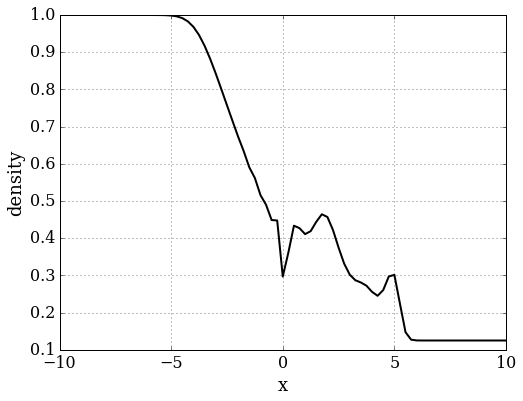

In [9]:
pyplot.figure(figsize=(8,6))
pyplot.grid(True)
pyplot.xlabel(r'x', fontsize=18)
pyplot.ylabel(r'density', fontsize=18)
#pyplot.title('Glider trajectory, flight time = %.2f' % T, fontsize=18)
pyplot.plot(x,rhoval, 'k-', lw=2);

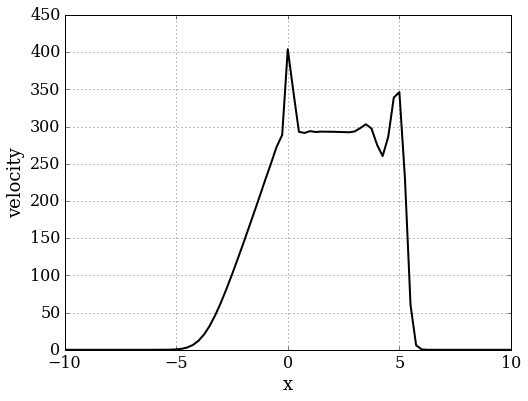

In [10]:
pyplot.figure(figsize=(8,6))
pyplot.grid(True)
pyplot.xlabel(r'x', fontsize=18)
pyplot.ylabel(r'velocity', fontsize=18)
#pyplot.title('Glider trajectory, flight time = %.2f' % T, fontsize=18)
pyplot.plot(x,uval, 'k-', lw=2);

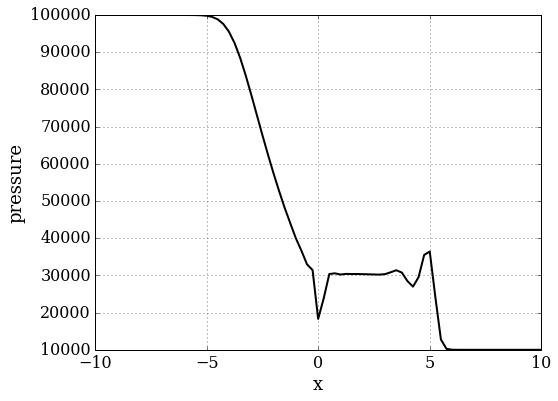

In [11]:
pyplot.figure(figsize=(8,6))
pyplot.grid(True)
pyplot.xlabel(r'x', fontsize=18)
pyplot.ylabel(r'pressure', fontsize=18)
#pyplot.title('Glider trajectory, flight time = %.2f' % T, fontsize=18)
pyplot.plot(x,pval, 'k-', lw=2);